### Loading Libraries & Google Collab Set Up

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 5.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=e4303b8fe595df98b7256d41ef14229fa21432719939b09f223eecd1b5f4af12
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import os, cv2, json
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import EfficientNetB4
from keras.optimizers import Adam

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

In [3]:
# Clear any logs from previous tensorboard runs
!rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [4]:
from google.colab import files
data_to_load = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Overview & Background
Cassava plants are a key food security crop grown by local farmers in Africa due to the plant's ability to withstand harsh outdoor elements. As the second-largest provider of carbohydrates in Africa and at least 80% of household farms in Sub-Saharan Africa grow this starchy root, I (as a data scientist) have been tasked with helping to identify viral diseases on the plants as this is a major reason of poor crop yields.

As it stands today, if farmers require help to detect disease within their crops, they must go through an arduous task of soliciting the help of government-funded agricultural experts, leading to delays in assessing crop damage and risk of destroying their entire crop base due to the spread of disease. As an added challenge, any image detection solution must perform well under low quality images, since African farmers may only have access to mobile-quality cameras with low-bandwidth.

I am now tasked to classify each cassava image into four disease categories or a fifth category indicating a healthy leaf. With my help, farmers may be able to quickly identify diseased plants, potentially saving their crops before they inflict irreparable damage.

In this project, we will train a convultional neural network that must have an accuracy score higher than ~61%. We demonstrate that by utilizing transfer learning, applying an EfficientNetB4 architecture, we yield a final validation accuracy score of ~86% in our model.

<p align="center">
<img src="https://github.com/Lwhieldon/Cassava-Leaf-Disease-Classification/blob/master/images/cassavafarmer.jpg?raw=true" height="200" />
</p>

### Data Gathering & Preparation

Let's review our data to understand how the image files interact with the labels as well as the train.csv file that tags the images to classes.

In [6]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.74G/5.76G [01:13<00:00, 92.7MB/s]
100% 5.76G/5.76G [01:13<00:00, 84.2MB/s]


The dataset is part of an active competition as of December 2020; note the competition will end February 2021. The competition introduces a dataset of 21,367 labeled images collected during a regular survey in Uganda. Most images were crowdsourced from farmers taking photos of their gardens, and annotated by experts at the National Crops Resources Research Institute (NaCRRI) in collaboration with the AI lab at Makerere University, Kampala. The image format and documentation within the competition most realistically represents what farmers would need to diagnose in real life.

Each Cassava leaf image is identified as:
<ul>
<li>Cassava Bacterial Blight (CBB)</li>
<li>Cassava Brown Streak Disease (CBSD)</li> 
<li>Cassava Green Mottle (CGM)</li> 
<li>Cassava Mosaic Disease (CMD)</li>
<li>Healthy</li>
</ul>

In [7]:
import zipfile
zip_ref = zipfile.ZipFile('cassava-leaf-disease-classification.zip', 'r')
zip_ref.extractall('cassava-leaf-disease-classification')
zip_ref.close()

As we can see below, the directory pulled from Kaggle contains the following information:

1. test_images: A single image to test our final model. Since the competition is ongoing, we have a single file to test. 
1. label_num_to_disease_map.json: This json file ties the labels tagged to an image (in train.csv file) to a long description of the label.
1. [train/test]_tfrecords: The image files in tfrecord format.
1. sample_submission.csv: A properly formatted sample submission, given the disclosed test set content.

  - image_id the image file name.

  - label the predicted ID code for the disease.

  We have ~21k training imagaes to add to our CNN. Let's get started!

In [8]:
WORK_DIR = os.getcwd()+'/cassava-leaf-disease-classification'
os.listdir(WORK_DIR)

['test_images',
 'label_num_to_disease_map.json',
 'train_tfrecords',
 'train_images',
 'train.csv',
 'test_tfrecords',
 'sample_submission.csv']

In [9]:
print('Train images: %d' %len(os.listdir(
    os.path.join(WORK_DIR, "train_images"))))

Train images: 21397


In [10]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [11]:
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
train_labels.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


Each Cassava leaf image is identified as:
<ul>
<li>Cassava Bacterial Blight (CBB)</li>
<li>Cassava Brown Streak Disease (CBSD)</li> 
<li>Cassava Green Mottle (CGM)</li> 
<li>Cassava Mosaic Disease (CMD)</li>
<li>Healthy</li>
</ul>

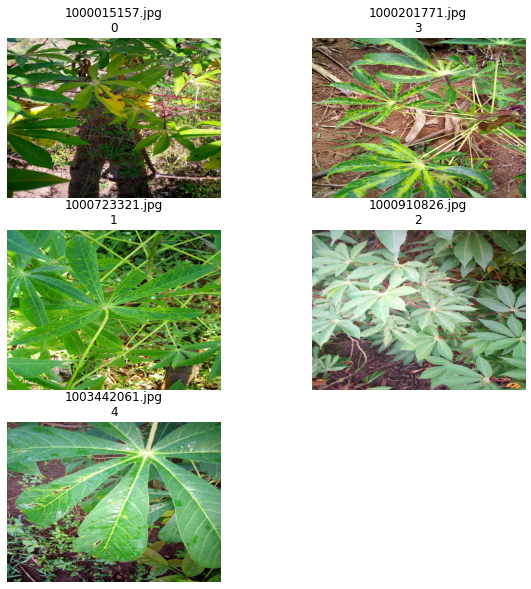

In [12]:
# Image sample from 5 different classes
sample_images = ['1000015157.jpg','1000723321.jpg','1000910826.jpg','1000201771.jpg','1003442061.jpg']
sample_images_df = train_labels[train_labels.image_id.isin(sample_images)]
plt.figure(figsize=(10,10))
for ind, (image_id, label) in enumerate(zip(sample_images_df.image_id, sample_images_df.label)):
    plt.subplot(3, 2, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.title('{}\n{}'.format(image_id,label))
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

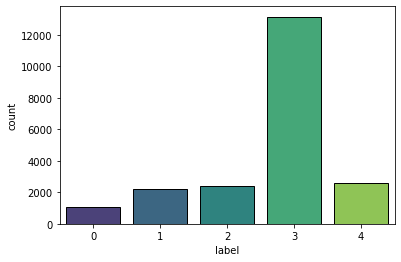

In [13]:
sns.countplot(train_labels.label, edgecolor = 'black',
              palette = sns.color_palette("viridis", 5))
plt.show()

We have imbalanced data with domination of third class: "Cassava Mosaic Disease (CMD)". Let's see how our model performs with this imbalanced dataset and so we will keep it in the training dataset for now.

### Some photos of dominant class (with CMD)

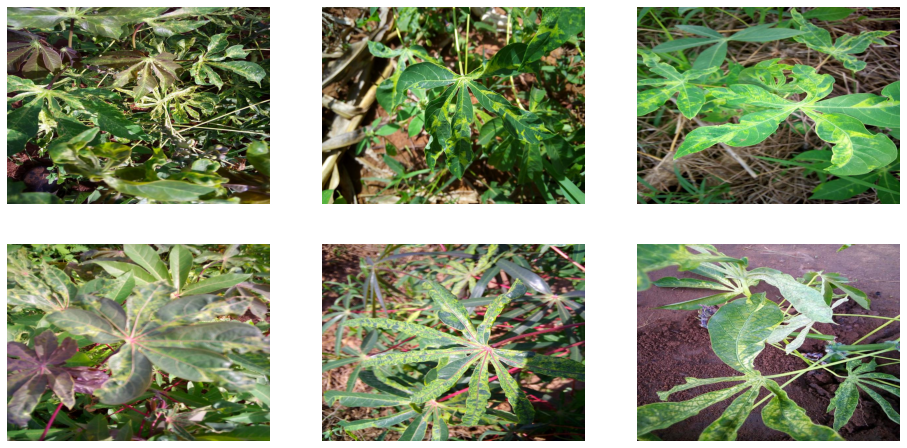

In [14]:
sample = train_labels[train_labels.label == 3].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

### Some photos of healthy plants

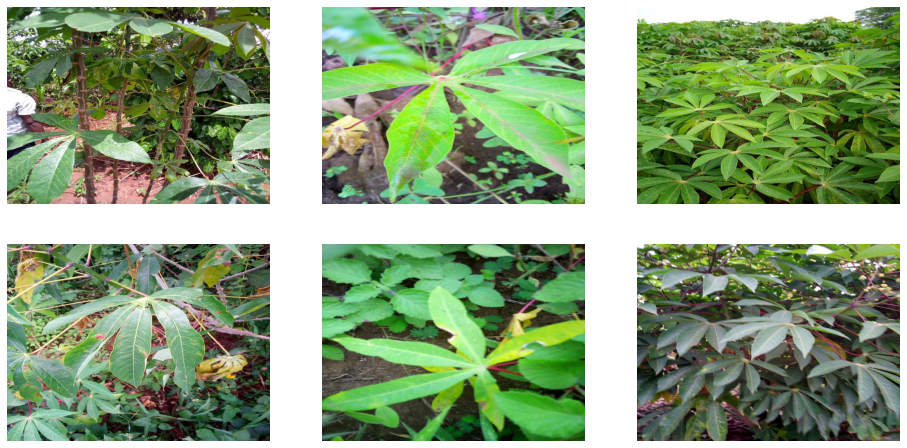

In [15]:
sample = train_labels[train_labels.label == 4].sample(6)
plt.figure(figsize=(16, 8))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(2, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

## The baseline level of accuracy

In [16]:
y_pred = [3] * len(train_labels.label)
print('The baseline accuracy: %.3f' 
      %accuracy_score(y_pred, train_labels.label))

The baseline accuracy: 0.615


Our future model must have accuracy better than 0.615.

## Modeling

In [17]:
BATCH_SIZE = 16
STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 10
TARGET_SIZE = 299

In [18]:
train_labels.label = train_labels.label.astype('str')
#validation_split parameter allows for us to split 20% of the data into the validation set automatically without train test split
#Then you can allow .flow_from_dataframe to breakout the train versus validation in the data
train_generator = ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     zoom_range = 0.2,
                                     cval = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     rotation_range = 5,
                                     fill_mode = 'constant',
                                     shear_range = 0.2,
                                     height_shift_range = 0.2,
                                     width_shift_range = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

validation_generator = ImageDataGenerator(validation_split = 0.2) \
    .flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


## Modeling

I will try EfficientNetB4. It will be my baseline NN for future improvements.

In [19]:
def create_model():
    model = models.Sequential()

    model.add(EfficientNetB4(include_top = False, weights = 'imagenet',
                             input_shape = (TARGET_SIZE, TARGET_SIZE, 3)))
    
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(5, activation = "softmax"))

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [20]:
model = create_model()


71688192/71686520 [==============================] - 3s 0us/step


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 10, 10, 1792)      17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 8965      
Total params: 17,682,788
Trainable params: 17,557,581
Non-trainable params: 125,207
_________________________________________________________________


In [22]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,                                     histogram_freq=1)
model_save = ModelCheckpoint('./best_baseline_model.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [tensorboard_callback,model_save, early_stop, reduce_lr]
    )

Epoch 1/10
   1/1069 [..............................] - ETA: 0s - loss: 1.7156 - acc: 0.1250WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1070/1069 [==============================] - ETA: 0s - loss: 0.6538 - acc: 0.7723
Epoch 00001: val_loss improved from inf to 0.57466, saving model to ./best_baseline_model.h5
1070/1069 [==============================] - 439s 410ms/step - loss: 0.6538 - acc: 0.7723 - val_loss: 0.5747 - val_acc: 0.8056
Epoch 2/10
 919/1069 [========================>.....] - ETA: 55s - loss: 0.5162 - acc: 0.8242

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

In [ ]:
model.save('./baseline_model.h5')

In [ ]:
ss = pd.read_csv(os.path.join(WORK_DIR, "sample_submission.csv"))
ss

In [ ]:
preds = []

for image_id in ss.image_id:
    image = Image.open(os.path.join(WORK_DIR,  "test_images", image_id))
    image = image.resize((TARGET_SIZE, TARGET_SIZE))
    image = np.expand_dims(image, axis = 0)
    preds.append(np.argmax(model.predict(image)))

ss['label'] = preds
ss

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
ss.to_csv('submission.csv', index = False)

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
os.chdir(os.getcwd()+'/drive/MyDrive/Cassava-Leaf-Disease-Classification')
print('The Current Working Directory is: ',os.getcwd())

In [ ]:
model.save('./baseline_model.h5')

Next items:

1. Apply Test Time Augmentation to increase scores
2. Scale images to larger than 299 x 299 x 3: Maybe try 448x448x3
3. Try other EfficientNetB architectures to see if model improves
4. Try oversampling other classification groups to rectify any loss or accuracy deprivation as a result of imbalanced data tied to CMD class